In [1]:
import pandas as pd
from joblib import load
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import QuantileTransformer
from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report

In [20]:
grid_model = load('../models/FINAL/logreg_gridsearch_CV_base_v_drug.joblib')
grid_results = pd.DataFrame(grid_model.cv_results_)
# grid_model = load("../models/logreg_gridsearch_model.joblib")

In [21]:
grid_results.sort_values('rank_test_F1-score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__C,param_qt__n_quantiles,param_qt__output_distribution,params,split0_test_Accuracy,split1_test_Accuracy,...,split4_test_F1-score,split5_test_F1-score,split6_test_F1-score,split7_test_F1-score,split8_test_F1-score,split9_test_F1-score,split10_test_F1-score,mean_test_F1-score,std_test_F1-score,rank_test_F1-score
12,3.425525,0.179535,21.484836,0.237384,11.2884,10,normal,"{'clf__C': 11.288378916846883, 'qt__n_quantile...",0.900000,0.633333,...,0.529618,0.749555,0.876052,0.945055,0.626377,0.505747,0.838095,0.739091,0.167332,1
11,3.360530,0.123101,21.150375,0.165755,4.28133,10,normal,"{'clf__C': 4.281332398719396, 'qt__n_quantiles...",0.888889,0.633333,...,0.568247,0.760909,0.837340,0.945373,0.604824,0.505747,0.783333,0.729798,0.161598,2
14,3.561438,0.067516,21.394338,0.201879,78.476,10,normal,"{'clf__C': 78.47599703514607, 'qt__n_quantiles...",0.911111,0.588889,...,0.507740,0.772166,0.921124,0.955896,0.533333,0.522523,0.848485,0.729480,0.179879,3
13,3.550600,0.104295,21.202388,0.209239,29.7635,10,normal,"{'clf__C': 29.763514416313132, 'qt__n_quantile...",0.922222,0.600000,...,0.557334,0.726522,0.874667,0.912812,0.558418,0.522523,0.848887,0.729423,0.166983,4
5,2.983005,0.089064,21.263451,0.173925,0.0127427,10,normal,"{'clf__C': 0.012742749857031334, 'qt__n_quanti...",0.688889,0.566667,...,0.671336,0.678932,0.798191,0.919229,0.533333,0.912356,0.785908,0.718687,0.153532,5


In [22]:
grid_results.sort_values('rank_test_F1-score').iloc[0,:]

mean_fit_time                                                              3.42553
std_fit_time                                                              0.179535
mean_score_time                                                            21.4848
std_score_time                                                            0.237384
param_clf__C                                                               11.2884
param_qt__n_quantiles                                                           10
param_qt__output_distribution                                               normal
params                           {'clf__C': 11.288378916846883, 'qt__n_quantile...
split0_test_Accuracy                                                           0.9
split1_test_Accuracy                                                      0.633333
split2_test_Accuracy                                                      0.977778
split3_test_Accuracy                                                      0.677778
spli

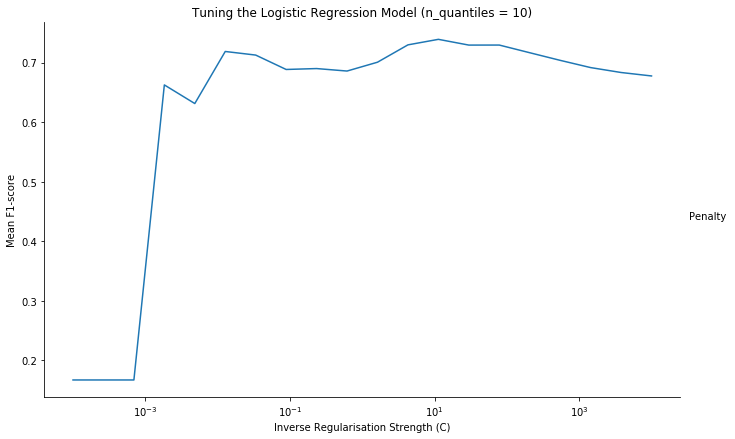

In [23]:
qt_10 = grid_results[grid_results['param_qt__n_quantiles'] == 10]
fg = sns.FacetGrid(data = qt_10, aspect=1.61, height=6)
fg.map(plt.semilogx, 'param_clf__C', 'mean_test_F1-score').add_legend(title='Penalty')
fg.set(xlabel='Inverse Regularisation Strength (C)', ylabel='Mean F1-score', title='Tuning the Logistic Regression Model (n_quantiles = 10)')
# plt.semilogx(grid_results['param_clf__C'], grid_results['mean_test_score'])
# fg.savefig('reports/figures/logreg_grid_penalty_qt_10')

- The l2 Model pretty much classifies everything as Ach. This is a pretty terrible model.  
- The l1 Model does better in classifying AT, but still fails to identify any baseline observations.  

> we need more scoring methods


In [53]:
fs = load('../models/FINAL/feature_selector_at_v_hex.joblib')

In [54]:
len(fs.relevant_features)

16238

In [55]:
min(fs.p_values)

4.203027474234754e-56